In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
from ipywidgets import interact, interact_manual

# Model

In [2]:
def curve(x):
    return (x/10)**3 - 6*(x/10)**2 + 4*x/10 + 30

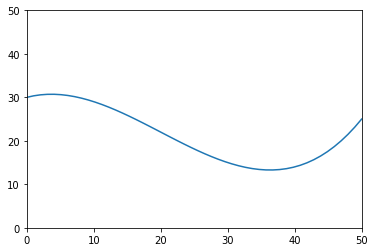

In [3]:
x = np.linspace(0, 50)
y = curve(x)

plt.figure()
plt.plot(x, y)
plt.xlim(0,50)
plt.ylim(0,50)
plt.show()

In [4]:
def generate_normal(i, j, v1=15., v2=7., var=1.0):
    v = curve(i)
    
    mu = np.ones_like(i, dtype=np.float64)
    type1 = v >= j
    mu[ type1 ] = v1
    
    type2 = v < j
    mu[ type2 ] = v2
    
    variance = np.zeros_like(i, dtype=np.float64)
    variance = np.abs(v - j)
    variance /= np.max(variance)
    variance = 1 - variance
    variance *= var
    
    return mu, variance

# Exponential decay function
For a distance $h$ in pixel, this function defines the decay of the covariance.
$$
    r(h) = exp( - \gamma h)
$$

In [5]:
def exponential(value, gamma):
    return np.exp( - gamma * value)

@interact(width=(2,50))
def interactive_exponential(width=2):
    x = np.arange(0,width)
    y = exponential(x, 1/np.log(width))
    plt.bar(x, y)
    plt.show()

interactive(children=(IntSlider(value=2, description='width', max=50, min=2), Output()), _dom_classes=('widget…

# Linear decay function
\begin{align}
    r(h) &= - \gamma h + 1, & \gamma &\in (0,1)
\end{align}

In [6]:
def linear(value, gamma):
    return - gamma * value + 1

@interact(width=(1,50))
def interactive_linear(width=1):
    x = np.arange(0,width)
    y = linear(x, 1/width)
    plt.bar(x, y)
    plt.show()

interactive(children=(IntSlider(value=1, description='width', max=50, min=1), Output()), _dom_classes=('widget…

In [8]:
def constant(value, width):
    return 1.0

@interact(width=(1,50))
def interactive_constant(width=1):
    x = np.arange(width)
    y = constant(x, width)
    plt.bar(x, y)
    plt.show()

interactive(children=(IntSlider(value=1, description='width', max=50, min=1), Output()), _dom_classes=('widget…

# Building the covariance matrix
Let $G = (V,A)$ be an unidirected graph with its vertices $|V| = n$ and its adjacency matrix $A$. This graph models a 2D grid, including the diagonal connections. While the adjacency matrix $A$ represents the closest points (1-hop away) of each point $i$, we can compute the connections, which are 2-hops away as followed:
\begin{align}
    A^{(2)} &= A \cdot A - A - \mathbf{I}.
\end{align}
Now, all entries of $A^{(2)}$, which are greater than zero are 2-hop away of the vertex corresponding to that pixel. The selfconnected case is represented by the identity matrix $\mathbf{I}$. This can be done for arbitrary distances $d$ as followed:
\begin{align}
    A^{(d)} &= \prod\limits^d_{i=1} A - \sum\limits^{d-1}_{j=1} A^{(i)} - \mathbf{I}
\end{align}
Please note, $A^{(d)}$ contains only the d-hop connections, while $A \cdot A$ contains entries representing connections from 0-hop (self-connected) till 2-hop.

Now, we construct a matrix $M \in \mathbb{R}^{n \times n}$, which uses the d-hop adjacency matrices $A^{(d)}$ by modulating them based on a distance funcion $r: \mathbb{N} \rightarrow \mathbb{R}$.
\begin{align}
    M &= \mathbf{I} ~ r(0) + \sum\limits^d_{i=1} A^{(i)} r(i)
\end{align}
To enforce a positive semi-definite matrix we multiply it with its transpose and normalize it:
\begin{align}
    \hat{R} &= M \cdot M^T \\
    R &= \frac{1}{r_{max}} \hat{R}, & r_{max} &= max \{v_{ij} \in \hat{R}\}
\end{align}

Let $V \in \mathbb{R}^{n \times n}$ be a matrix, which only has entries in its diagonals. Those entries represent the variance of a pixel $i$:
\begin{align}
    V_{ij} = \left\{\begin{array}{c}
        \sigma_i \\
        0
    \end{array} \begin{array}{c}
        & i = j \\
        & i \neq j
    \end{array}
    \right.
\end{align}

Both, the positive semi-definete normalized distance matrix $M$ and the matrix $V$, containing the variances produce by their product a covariance matrix $C$ with a decaying covariance depending on the distance of the vertex:
\begin{align}
    C &= V \cdot M \cdot V \\
    C_{i,j} &= \left\{ \begin{array}{cc}
        \sigma_i^2 & i=j \\
        \rho_{i,j} \sigma_i \sigma_j & i \neq j
    \end{array}\right.
\end{align}

In [20]:
def build_covariance_matrix(variance, function=exponential, width=3):
    n = variance.shape[0]
    var = np.diag(variance.flatten())
    
    distance_map = [
        np.eye(n*n)
    ]
    
    if width > 1:
        # connect each row
        tpRow = np.zeros((n,1), dtype=np.float32)
        tpRow[1] = 1
        offdi = la.toeplitz(tpRow)
        # connect each column
        tpEdge = np.zeros((n,1), dtype=np.float32)
        tpEdge[0] = 1
        offedge = la.toeplitz(tpEdge)
        #connect diagonals
        tpDiag = np.zeros((n,1), dtype=np.float32)
        tpDiag[1] = 1
        offdiag = la.toeplitz(tpDiag)

        I = np.eye(n, dtype=np.float32)
        Ileft = np.roll(I, 1, axis=0) + np.roll(I, -1, axis=0)
        Ileft[0,n-1] = 0
        Ileft[n-1,0] = 0

        A = np.kron(I, offdi) + np.kron(Ileft, offedge) + np.kron(Ileft, offdiag)
        if function == linear:
            A *= function(1, 1.0/width)
        else:
            A *= function(1, 1/np.log(width))
        A *= 0.01
        
        distance_map.append(A)
        
    for weight in range(2, width//2):
        A_depth = distance_map[-1] @ distance_map[1]
        A_depth[ A_depth > 0 ] = 1.0
        for A_prev in distance_map:
            A_depth[ A_prev > 0 ] = 0.0
            
        if function == linear:
            A_depth *= function(weight, 1.0/width)
        else:
            A_depth *= function(weight, 1/np.log(width))
        A_depth *= 0.01
            
        distance_map.append(A_depth)

        
    # enforce positive semi-definite
    R = np.sum(distance_map, axis=0)
    #R = R @ R.T
    #R /= R.max()
    covariance = var @ R @ var
    
    return covariance

# Realizations

In [21]:
@interact_manual(mean1=(10.0,20.0), mean2=(10.0,20.0), variance=(0.5,10.0), width=(1,50), variance_model=['edge', 'inv_edge', 'constant'], decay_function=['exponential', 'linear', 'constant'])
def generate_samples(mean1=15.0, mean2=13.0, variance=1.0, width=3, variance_model='edge', decay_function='exponential'):
    x = np.arange(50)
    y = np.arange(50)
    xx, yy = np.meshgrid(x, y)
    
    mean, variance_map = generate_normal(xx, yy, mean1, mean2, variance)
    
    if variance_model == 'edge':
        used_variance = variance_map
    elif variance_model == 'inv_edge':
        used_variance = variance - variance_map
    else:
        used_variance = np.ones_like(variance_map) * variance
        
    if decay_function == 'constant':
        decay_func = constant
    elif decay_function == 'linear':
        decay_func = linear
    else:
        decay_func = exponential
        
    covariance = build_covariance_matrix(used_variance, decay_func, width)
    
    impulse = np.zeros_like(mean)
    impulse[mean.shape[0]//4*3, mean.shape[1]//4*3] = 1.0
    impulse[mean.shape[0]//2, mean.shape[1]//2] = 1.0
    impulse[mean.shape[0]//4, mean.shape[1]//4] = 1.0
    impulse = impulse.flatten()

    plt.figure(figsize=(18,12))
    plt.subplot(2,2,1)
    plt.title('Mean $\mu$')
    plt.imshow(mean)
    plt.colorbar()

    plt.subplot(2,2,2)
    plt.title('Standard deviation $\sigma$')
    plt.imshow(used_variance)
    plt.colorbar()

    plt.subplot(2,2,3)
    plt.title('Covariance $\Sigma$')
    plt.imshow(covariance)
    plt.colorbar()

    plt.subplot(2,2,4)
    plt.title('Covariance of single points')
    plt.imshow( (impulse @ covariance).reshape(mean.shape) )
    plt.colorbar()

    plt.show()
    
    plt.figure(figsize=(18,8))
    for i in range(6):
        plt.subplot(2,3,i+1)
        
        sample = np.random.multivariate_normal(mean.flatten(), covariance)

        plt.imshow(sample.reshape(mean.shape))
        plt.colorbar()
        
    plt.show()

interactive(children=(FloatSlider(value=15.0, description='mean1', max=20.0, min=10.0), FloatSlider(value=13.0…

# Validation

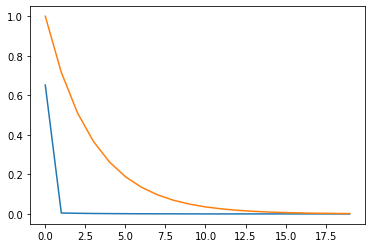

In [24]:
mean1 = 15.
mean2 = 13.
variance = 1.0
decay_function = exponential
variance_model = 'edge'
width = 20

x = np.arange(50)
y = np.arange(50)
xx, yy = np.meshgrid(x, y)

mean, variance_map = generate_normal(xx, yy, mean1, mean2, variance)

if variance_model == 'edge':
    used_variance = variance_map
elif variance_model == 'inv_edge':
    used_variance = variance - variance_map
else:
    used_variance = np.ones_like(variance_map) * variance
covariance = build_covariance_matrix(used_variance, decay_function, width)

impulse = np.zeros_like(mean)
impulse[mean.shape[0]//2, mean.shape[1]//2] = 1.0
impulse = impulse.flatten()

response = (impulse @ covariance).reshape(mean.shape)

x_val = np.arange(width)

if decay_function == linear:
    y_val = decay_function(x_val, 1.0/width)
else:
    y_val = decay_function(x_val, 1/np.log(width))

plt.plot(response[mean.shape[0]//2,mean.shape[1]//2:mean.shape[1]//2+width])
plt.plot(x_val, y_val)
plt.show()